## Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, skew, chi2_contingency, ttest_ind
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, skew, chi2_contingency, ttest_ind
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from src import soporte as sp


In [2]:
#Abrimos el csv
df = pd.read_csv("files/df_limpio.csv")

1. Preparación de Datos: Filtra el conjunto de datos para incluir únicamente las columnas relevantes:
'Flights Booked' y 'Education'.

In [3]:
df_preparacion_datos = df[["Flights Booked", "Education"]]
df_preparacion_datos

,Flights Booked,Education
0,3,Bachelor
1,10,College
2,6,College
3,0,Bachelor
4,0,Bachelor
...,...,...
401683,0,College
401684,0,Doctor
401685,3,Bachelor
401686,0,College


2. Análisis Descriptivo: Agrupa los datos por nivel educativo y calcula estadísticas descriptivas
básicas (como el promedio, la desviación estandar) del número de vuelos reservados para cada
grupo.

In [4]:
# Estadísticas descriptivas incluyendo la varianza, el mínimo y la mediana.
estadistica = df.groupby("Education")["Flights Booked"].agg(["mean", "median", "std", "var", "min", "max"])
estadistica

,mean,median,std,var,min,max
Education,,,,,,
Bachelor,4.112363,1.0,5.224957,27.300172,0,21
College,4.172349,1.0,5.250673,27.569572,0,21
Doctor,4.177736,1.0,5.262027,27.688930,0,21
High School or Below,4.181319,1.0,5.248480,27.546543,0,21
Master,4.208743,1.0,5.224245,27.292736,0,21


3. Prueba Estadística: Realiza una prueba A/B Testing para determinar si existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

In [5]:
#Sacamos los valores únicos de la columna Education
df["Education"].unique()

array(['Bachelor', 'College', 'Master', 'High School or Below', 'Doctor'],
      dtype=object)

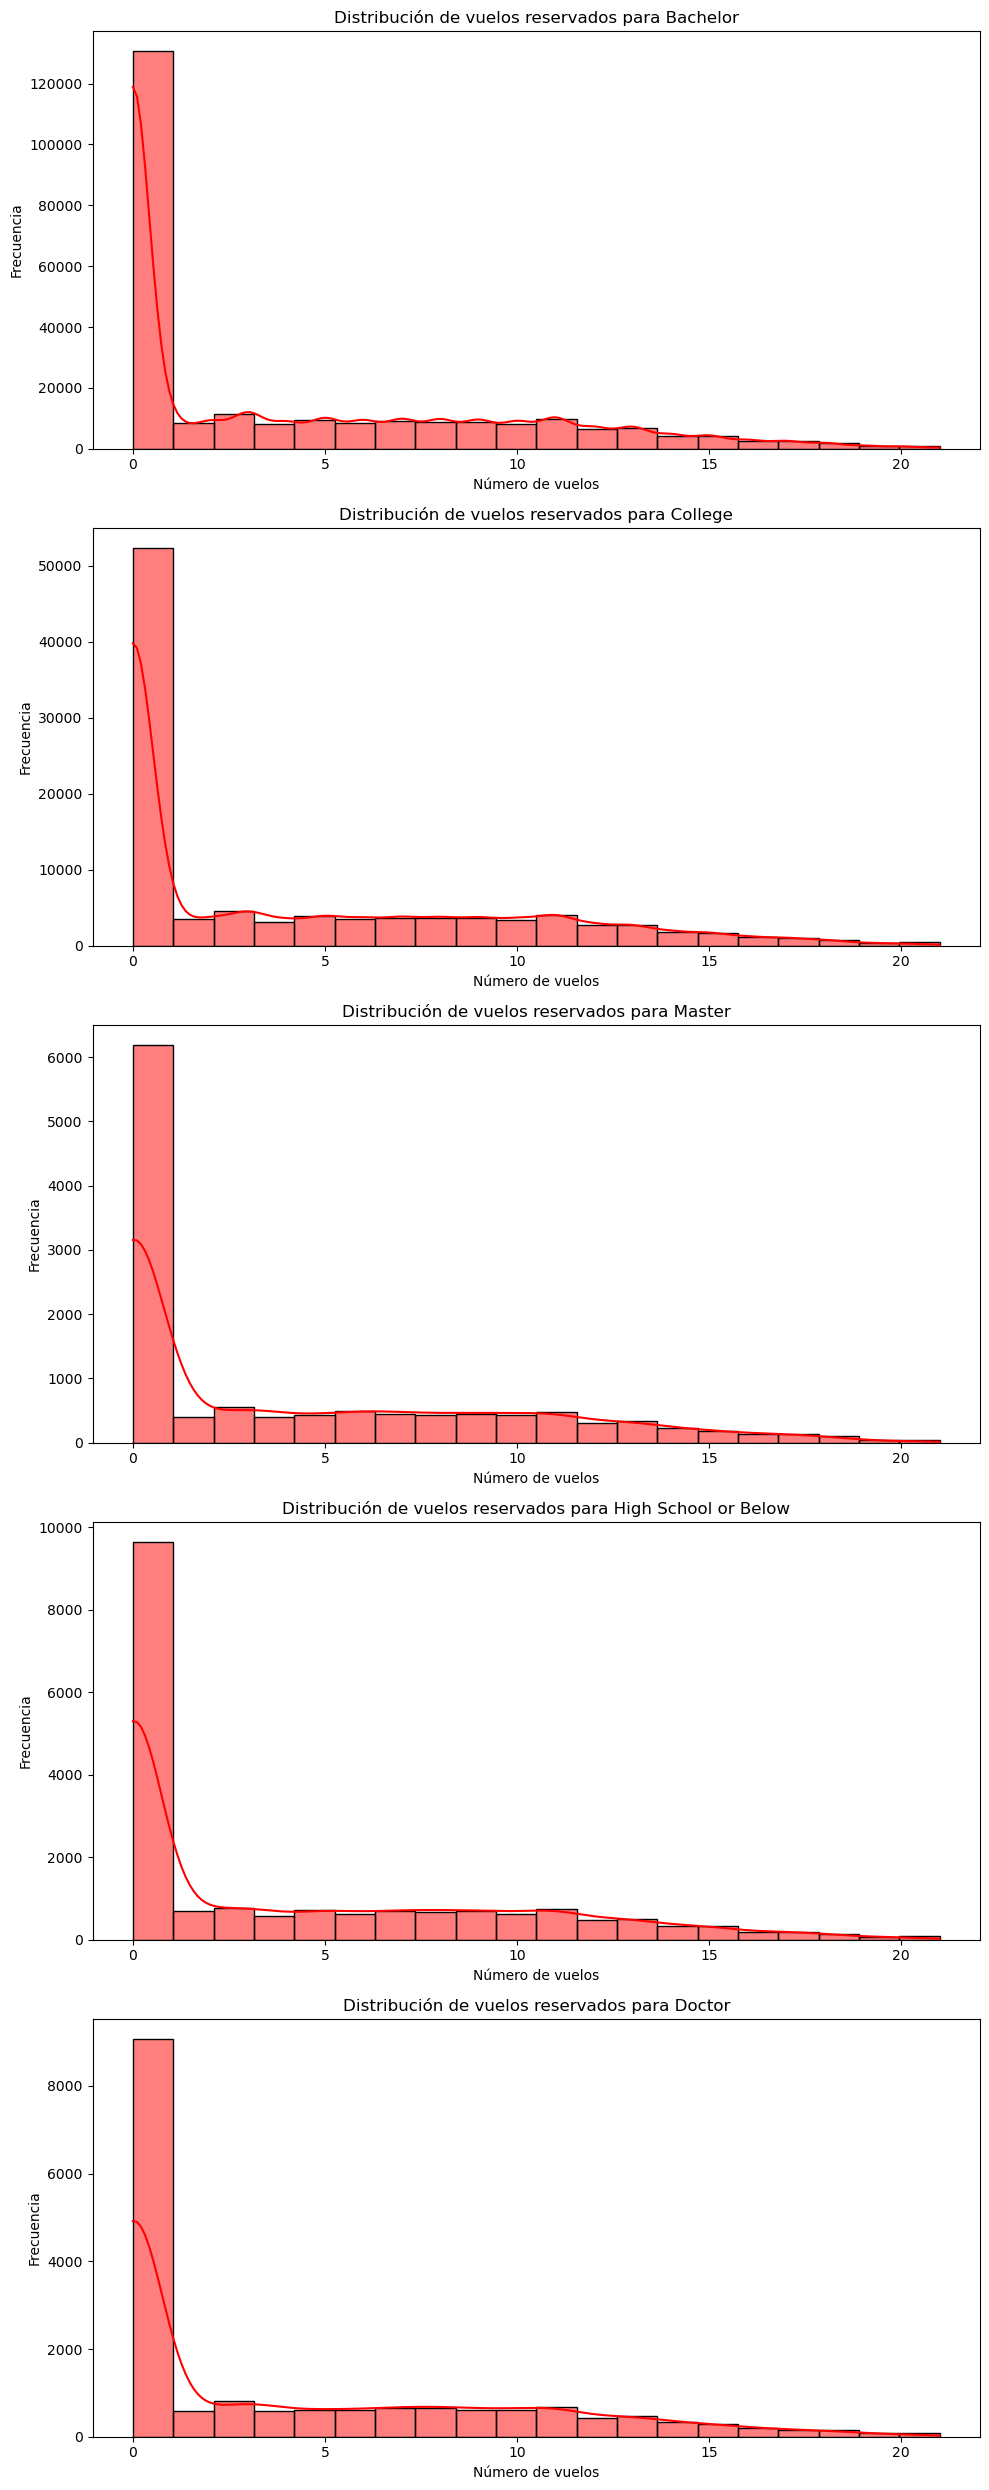

In [7]:
# Obtenemos los niveles educativos únicos.
niveles_educativos = df['Education'].unique()

# Creamos una figura con subplots, uno por cada nivel educativo.
fig, axes = plt.subplots(nrows=len(niveles_educativos), figsize=(10, 5 * len(niveles_educativos)))

# Iteramos sobre los niveles educativos y crear un histograma para cada uno.
for i, nivel in enumerate(niveles_educativos):
    sns.histplot(x='Flights Booked', 
                data=df[df['Education'] == nivel], 
                ax=axes[i],
                color='red',
                kde=True,
                bins=20)
    axes[i].set_title(f'Distribución de vuelos reservados para {nivel}')
    axes[i].set_xlabel('Número de vuelos')
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

La distribución está sesgada hacia la derecha en todas las gráficas, lo que indica que la mayoría de los clientes reservan un número bajo de vuelos.

El pico más alto de la distribución se encuentra alrededor de 0-1 vuelos, la mayoría reservan un vuelo o ninguno.

La cola de la distribución se extiende hacia la derecha, indicando valores atípicos. Hay algunos individuos que reservan un número alto de vuelos en comparación con el resto.

Los datos no siguen una distribución normal para ninguno de los niveles educativos.

In [ ]:
# Crear una tabla de contingencia entre 'Education' y 'flights_booked'
tabla_contingencia = pd.crosstab(df["Education"], df["Flights Booked"])

# Mostrar el resultado
print(tabla_contingencia)


Flights Booked            0     1     2      3     4     5     6     7     8   \
Education                                                                       
Bachelor              122785  7879  8351  11342  7972  9380  8564  9006  8904   
College                49208  3090  3470   4565  3184  3847  3480  3658  3592   
Doctor                  8490   575   580    812   584   598   602   653   659   
High School or Below    9006   626   705    779   571   712   625   695   683   
Master                  5802   383   404    557   406   426   487   454   432   

Flights Booked          9   ...    12    13    14    15    16    17    18  \
Education                   ...                                             
Bachelor              8761  ...  6472  6776  4345  4072  2672  2384  1807   
College               3587  ...  2666  2691  1807  1695  1144  1020   764   
Doctor                 613  ...   425   464   326   285   205   157   142   
High School or Below   685  ...   483   497   3

No nos da informacion valiosa.

In [ ]:
sp.normalidad(df, "Flights Booked")

Para la columna Flights Booked los datos no siguen una distribución normal.


In [ ]:
# Obtenemos los niveles educativos únicos.
niveles_educativos = df['Education'].unique()

# Creamos una lista para almacenar los datos de cada nivel educativo.
flights_booked_groups = []

# Iteramos por cada nivel educativo y agregar los datos a la lista.
for nivel in niveles_educativos:
    flights_booked_grupo = df[df['Education'] == nivel]['Flights Booked']
    flights_booked_groups.append(flights_booked_grupo)

# Realizamos la prueba de Levene con todos los grupos.
statistic, p_value = stats.levene(*flights_booked_groups)

# Imprimimos los resultados.
print("Prueba de Levene para todos los niveles educativos:")
print(f"  Estadístico de Levene: {statistic}")
print(f"  p-valor: {p_value}")

# Evaluamos la homogeneidad de varianzas.
if p_value > 0.05:
    print("Las varianzas son homogéneas entre todos los grupos.")
else:
    print("Las varianzas NO son homogéneas entre todos los grupos.")

Prueba de Levene para todos los niveles educativos:
  Estadístico de Levene: 3.2748955225079426
  p-valor: 0.010800178123097486
Las varianzas NO son homogéneas entre todos los grupos.


Nos decantamos por la prueba de Mann-Whitney, ya que los datos no tiene una distribucion normal y no hay homogeneidad.

In [ ]:
 # Obtenemos los niveles educativos únicos.
niveles_educativos = df['Education'].unique() 
vuelos_grupos = []

# Creamos una lista de los grupos de vuelos por nivel educativo.
for nivel in niveles_educativos:
    vuelos_grupos.append(df[df['Education'] == nivel]['Flights Booked'])

# Realizamos el test de Mann-Whitney para todas las posibles combinaciones de grupos.
for i in range(len(vuelos_grupos)):
    for j in range(i+1, len(vuelos_grupos)):
        # Comparamos los grupos i y j.
        statistic, p_value = stats.mannwhitneyu(vuelos_grupos[i], vuelos_grupos[j])
        
        # Imprimimos los nombres de los grupos que estamos comparando.
        print(f"Comparación entre los grupos {niveles_educativos[i]} y {niveles_educativos[j]}:")
        print(f"  Estadístico U: {statistic}")
        print(f"  p-valor: {p_value}")
        
        # Evaluamos si hay una diferencia significativa entre las medianas.
        if p_value < 0.05:
            print("  Hay una diferencia significativa entre las medianas de los dos grupos.")
        else:
            print("  No hay una diferencia significativa entre las medianas de los dos grupos.")
        print()  # Salto de línea para mayor claridad en la salida.


Comparación entre los grupos Bachelor y College:
  Estadístico U: 12706979252.0
  p-valor: 0.0024209027206201113
  Hay una diferencia significativa entre las medianas de los dos grupos.

Comparación entre los grupos Bachelor y Master:
  Estadístico U: 1513281130.0
  p-valor: 0.012540622151813733
  Hay una diferencia significativa entre las medianas de los dos grupos.

Comparación entre los grupos Bachelor y High School or Below:
  Estadístico U: 2339068045.0
  p-valor: 0.038283441340283386
  Hay una diferencia significativa entre las medianas de los dos grupos.

Comparación entre los grupos Bachelor y Doctor:
  Estadístico U: 2198807816.5
  p-valor: 0.0973740259379844
  No hay una diferencia significativa entre las medianas de los dos grupos.

Comparación entre los grupos College y Master:
  Estadístico U: 616070308.5
  p-valor: 0.21961086039163646
  No hay una diferencia significativa entre las medianas de los dos grupos.

Comparación entre los grupos College y High School or Below:
 

Levene:

si p_value > 0.05 --> homogeneidad de varianzas

si p_value < 0.05 --> no homogeneidad